In [2]:
import xmitgcm
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numba

In [3]:
# function to load in the data
# data_dir is location of data
# prefix is type of data to load in (dyn, layersDiags)
def getoutput(data_dir,prefix):
    deltaTClock = 21600.
    grid_dir = './K50grid/'
    data = open_mdsdataset(data_dir,grid_dir,delta_t=deltaTClock,prefix=prefix,geometry='sphericalpolar',default_dtype=np.dtype)
    return data

In [3]:
dyn50=getoutput('./K50/','dyn')
dyn500=getoutput('./K500/','dyn')
dyn5000=getoutput('./K5000/','dyn')
#dyn5000=dyn5000.where(dyn5000['iter']>6.8e6,drop=True).isel(time=slice(29,35)).mean('time')
#lay50=getoutput('./K50/','layersDiags').isel(time=-1)
#lay500=getoutput('./K500/','layersDiags').isel(time=-1)
#ay5000=getoutput('./K5000/','layersDiags').isel(time=-1)


In [28]:
# iter is a python reserved word
# helpful renaming function
#dyn50=dyn50.rename({'iter':'niter'})

In [4]:
#Control all font sizes on all plots
matplotlib.rcParams.update({'font.size': 12})

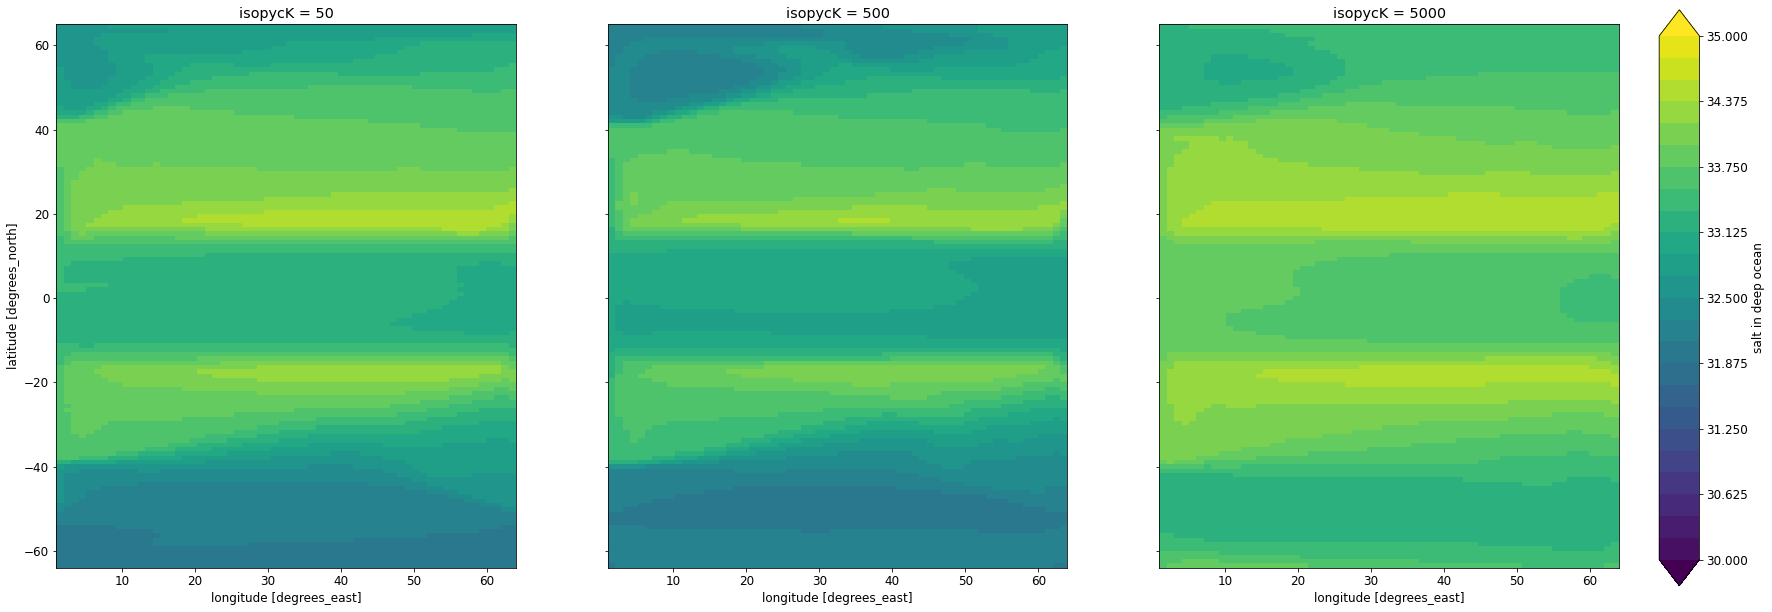

In [31]:
bouy50=dyn50['SALT'][0][1:-1,1:-1]*dyn50['dxF'][1:-1,1:-1].cumsum('XC')/dyn50['dxF'][1:-1,1:-1].cumsum('XC')
bouy500=dyn500['SALT'][0][1:-1,1:-1]*dyn500['dxF'][1:-1,1:-1].cumsum('XC')/dyn500['dxF'][1:-1,1:-1].cumsum('XC')
bouy5000=dyn5000['SALT'][0][1:-1,1:-1]*dyn5000['dxF'][1:-1,1:-1].cumsum('XC')/dyn5000['dxF'][1:-1,1:-1].cumsum('XC')
fig, axs = plt.subplots(ncols=3,figsize=(28,10),sharey=True)
#bouy50=dyn50['THETA'][0][1:-1,1:-1]
#bouy500=dyn500['THETA'][0][1:-1,1:-1]
#bouy5000=dyn5000['THETA'][0][1:-1,1:-1]
a=(bouy50).plot(ax=axs[0],vmin=30,vmax=35,levels=25,extend='both',add_colorbar=False,add_labels=True)
b=(bouy500).plot(ax=axs[1],vmin=30,vmax=35,levels=25,extend='both',add_colorbar=False)
c=(bouy5000).plot(ax=axs[2],vmin=30,vmax=35,levels=25,extend='both',add_colorbar=False)
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
plt.colorbar(a, cax=cax,label='salt in deep ocean')
#plt.title( 'K=50')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('isopycK = 50')
axs[1].set_title('isopycK = 500')
axs[2].set_title('isopycK = 5000')
plt.savefig('Temp.png')

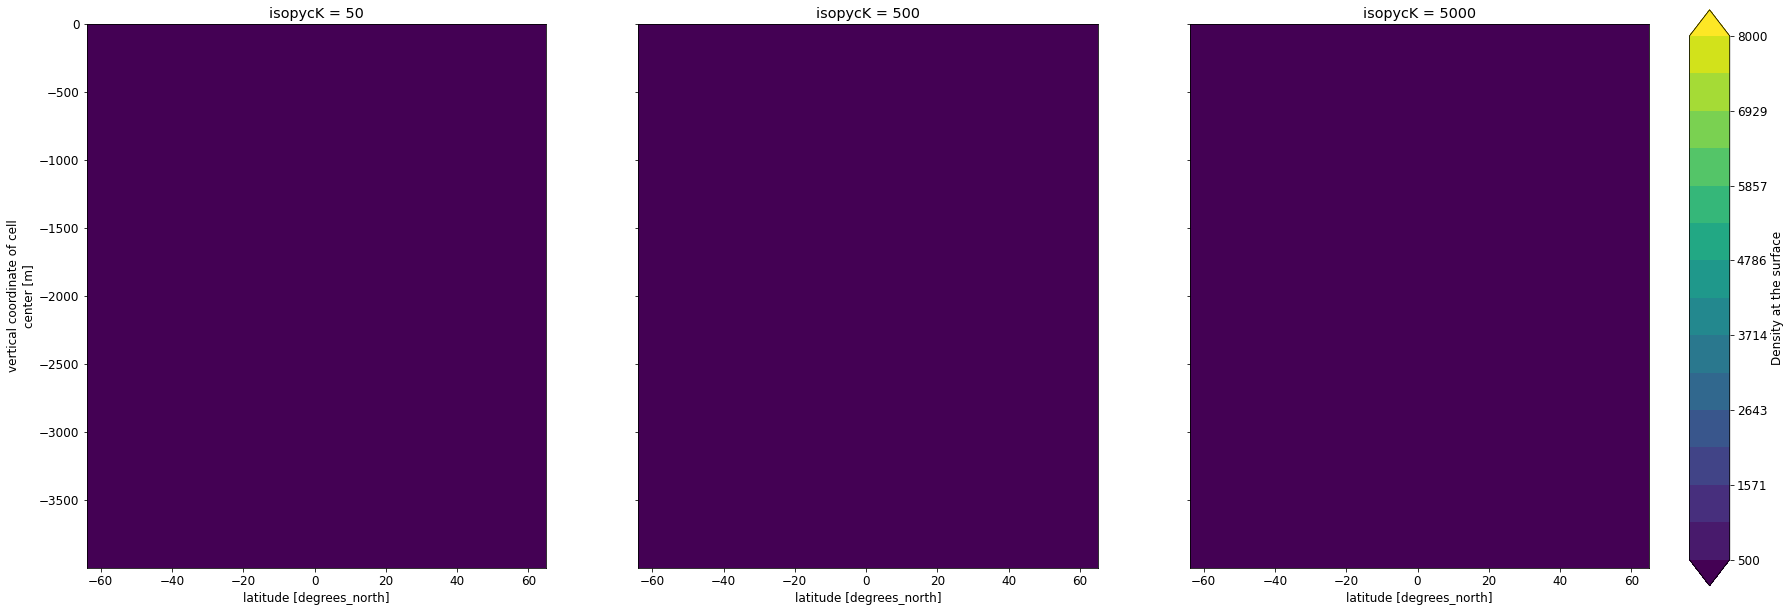

In [139]:
fig, axs = plt.subplots(ncols=3,figsize=(28,10),sharey=True)
bouyancy50=bouy(dyn50)
bouyancy500=bouy(dyn500)
bouyancy5000=bouy(dyn5000)
a=(bouyancy50).plot(ax=axs[0],vmin=500,vmax=8000,levels=15,extend='both',add_colorbar=False,add_labels=True)
b=(bouyancy500).plot(ax=axs[1],vmin=500,vmax=8000,levels=15,extend='both',add_colorbar=False)
c=(bouyancy5000).plot(ax=axs[2],vmin=500,vmax=8000,levels=15,extend='both',add_colorbar=False)
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
plt.colorbar(a, cax=cax,label='Density at the surface')
#plt.title( 'K=50')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('isopycK = 50')
axs[1].set_title('isopycK = 500')
axs[2].set_title('isopycK = 5000')
plt.savefig('Density.png')

In [129]:
#mean density
def bouy(dyn):
    weights = dyn['dxF']
    bouy=((9.81*(2e-4*dyn['THETA']-7.4e-4*(dyn['SALT']-35)))[:,:-1,:-1]*weights).mean('XC')
    return bouy

In [138]:
def bouy(dyn):
    weights = dyn['dxF']
    bouy=(((9.81*(2e-4*dyn['THETA']-7.4e-4*(dyn['SALT']-35)))[:,1:-1,1:-1]*weights).sum('XC')/dyn['dxF']).sum('XC')
    return bouy

In [32]:
def coverter(lay):
    weight=lay['dxG'][1:-1,1:-1]
    density_to_depth = ((lay['LaHs1RHO'][:,1:-1,1:-1].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))/(lay['dxG'][1:-1,1:-1].sum('XC'))
    stream1 = ((lay['LaVH1RHO'][1,1:-1,1:-1].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    layers_depth=lay['LaHs1RHO'][1,1:-1,1:-1].mean('XC').cumsum('layer_1RHO_center')
    layers_depth_atl=((lay['LaHs1RHO'][1,1:-1,1:-1]*lay['dxG'][1:-1,1:-1]).sum('XC')/lay['dxG'][1:-1,1:-1].sum('XC')).cumsum('layer_1RHO_center')
    stream1.coords['depth']=-layers_depth_atl[1:-1,1:-1]
    layer_1RHO_center_new = xr.DataArray(layers_depth_atl, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': lay.layer_1RHO_bounds[:-1],'YG':lay.YG})
    layer2D,_=(xr.broadcast(-9.81*(lay.layer_1RHO_bounds-35)/1035, lay.YG))
    layer2D.coords['depth']=(-layer_1RHO_center_new)
    return stream1,layer2D

ValueError: 'layer_1RHO_center' not found in array dimensions ('YG',)

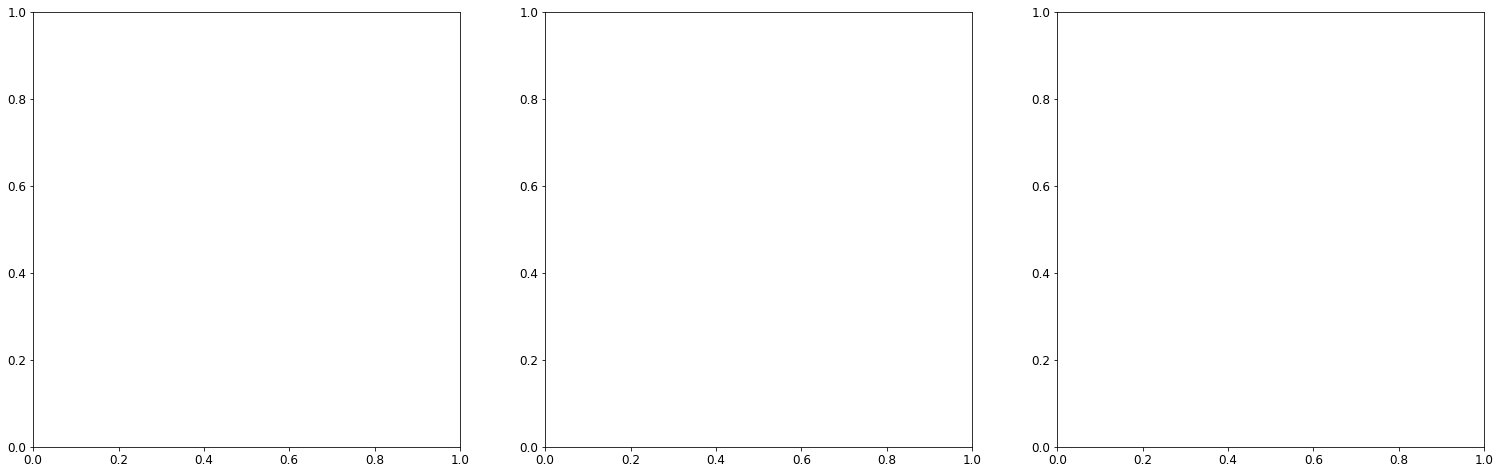

In [33]:
fig, axs = plt.subplots(ncols=3,figsize=(26,8))
mins=-7.5
maxs=7.5
cmap='seismic'
stream50,con50 = coverter(lay50)
stream500, con500 = coverter(lay500)
stream5000, con5000 = coverter(lay5000)
a = (stream50/1e6).plot.contourf(ax=axs[0],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)
b = (stream500/1e6).plot.contourf(ax=axs[1],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)
C = (stream5000/1e6).plot.contourf(ax=axs[2],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)

aa=con50.plot.contour(ax=axs[0],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con50.plot.contour(ax=axs[0],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
bb=con500.plot.contour(ax=axs[1],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con500.plot.contour(ax=axs[1],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
cc=con5000.plot.contour(ax=axs[2],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con5000.plot.contour(ax=axs[2],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
axs[0].clabel(aa, aa.levels, inline=True,  fontsize=10)
axs[1].clabel(bb, bb.levels, inline=True,  fontsize=10)
axs[2].clabel(cc, cc.levels, inline=True,  fontsize=10)
axs[0].set_title('isopycK = 50'),
axs[1].set_title('isopycK = 500')
axs[2].set_title('isopycK = 5000')
plt.savefig('convert_stream.png')

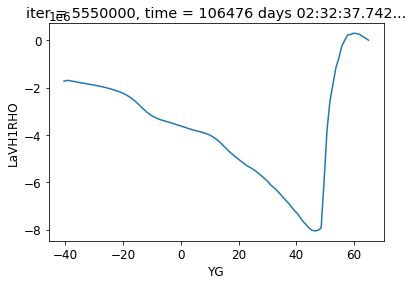

In [168]:
weight=lay50['dxG']
stream = ((lay50['LaVH1RHO'][14:,24:].weighted(weight)).sum('XC').sum('layer_1RHO_center'))
stream.plot()

/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


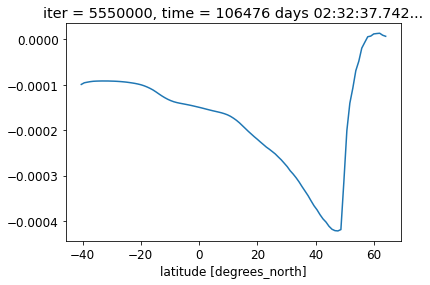

In [172]:
start=14
#fig,ax=plt.subplots(1,1)
thing=(lay50['LaVH1RHO'][start:-1,24:,:].sum('layer_1RHO_center')/lay50['LaHs1RHO'][start:-1,24:,:-1].sum('layer_1RHO_center')).mean('XC')
#ax.set_ylabel('Velocity (m/s)')
#ax.set_ylim(-0.0022,0)
#ax.grid(True)
thing.plot()

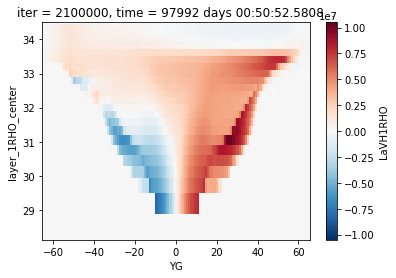

In [50]:
weight=lay50['dxG']
stream1 = ((lay50['LaVH1RHO'].weighted(weight)).sum('XC').cumsum('layer_1RHO_center')[-1])
stream1.plot()

In [63]:
# function to calculate streamfunction in density coordinates
def laystreamfunction(lay):
    weight=lay['dxG'][1:-1,1:-1]
    stream = ((lay['LaVH1RHO'][:,1:-1,1:-1].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    return stream[:,20:]

In [64]:
stream50=laystreamfunction(lay50)
stream500=laystreamfunction(lay500)
stream5000=laystreamfunction(lay5000)

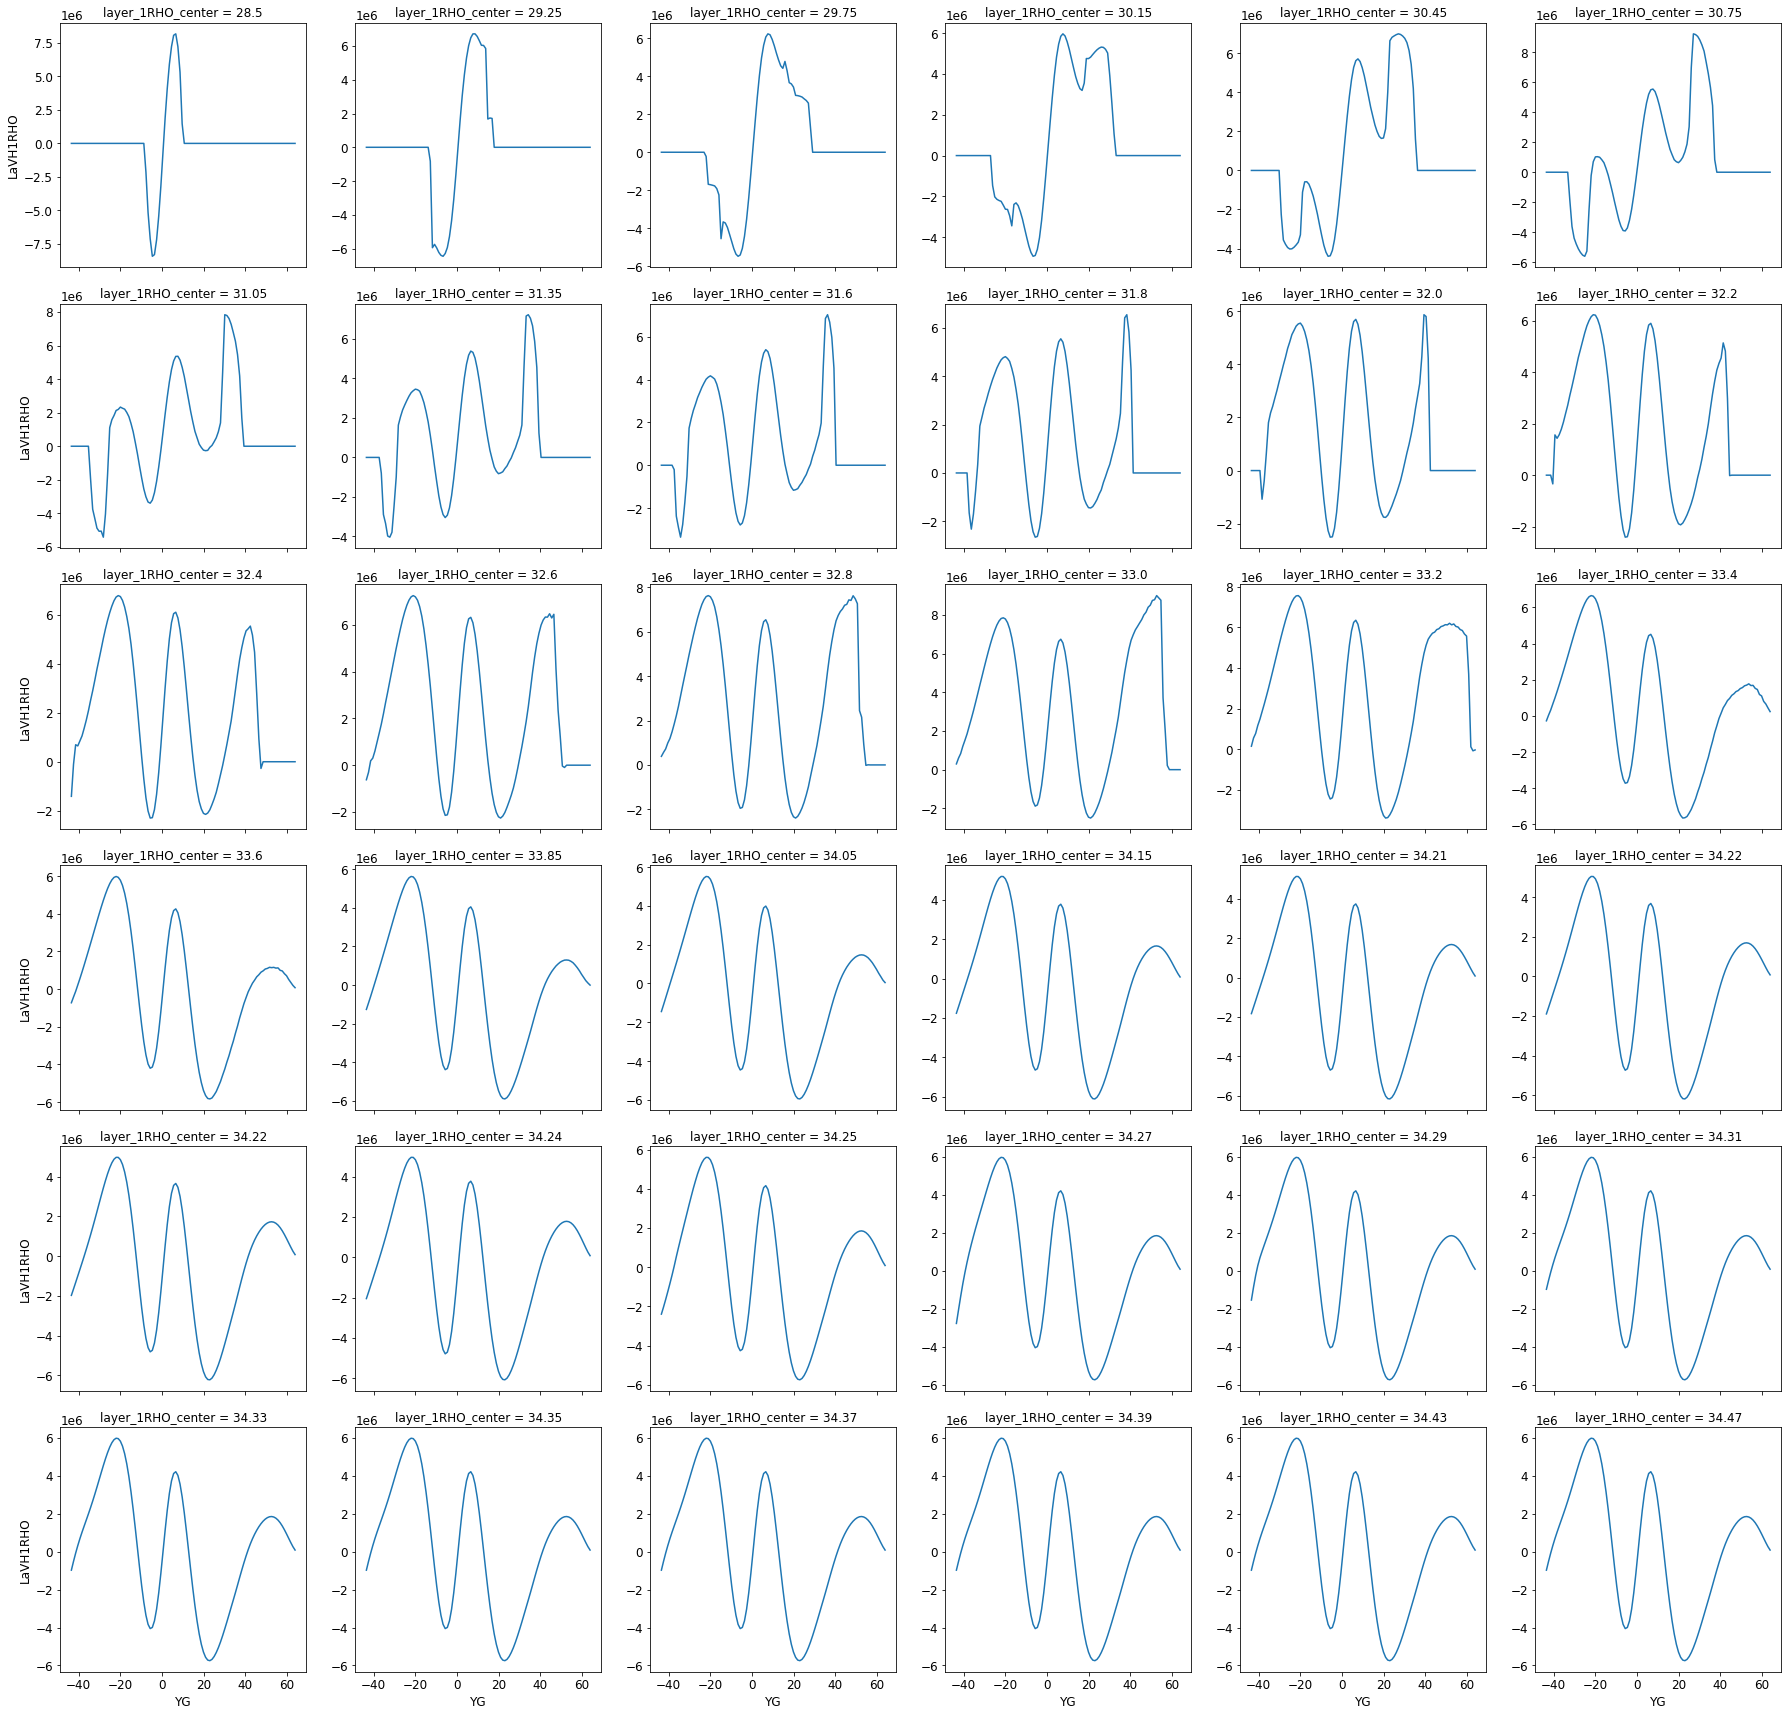

In [65]:
stream5000.plot.line(size=4,col='layer_1RHO_center',col_wrap=6,sharey=False)
#plt.savefig('each_layer_streamfunction.png')

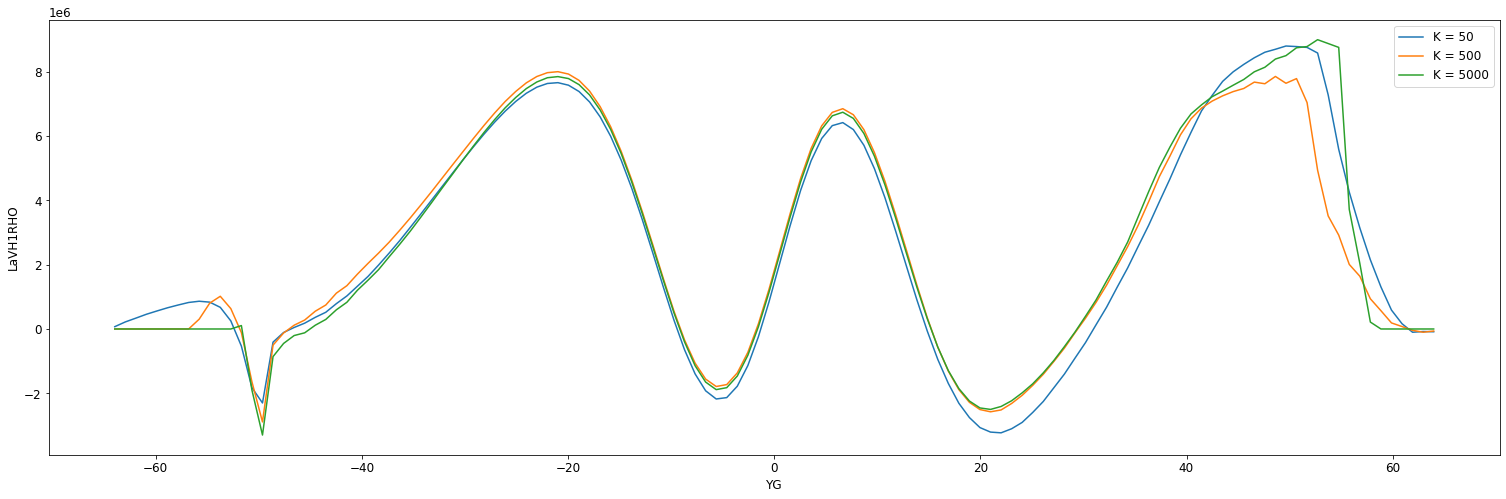

In [62]:
max5000=stream5000.sel(layer_1RHO_center=33.0)
max500=stream500.sel(layer_1RHO_center=32.6)
max50=stream50.sel(layer_1RHO_center=32.800003)
fig, axs = plt.subplots(ncols=1,figsize=(26,8))
max50.plot(ax=axs,label='K = 50')
max500.plot(ax=axs, label='K = 500')
max5000.plot(ax=axs, label='K = 5000')
plt.legend()
plt.title('')
plt.savefig('lineplot.png')

In [59]:
stream5000.values.max()

9230574.0

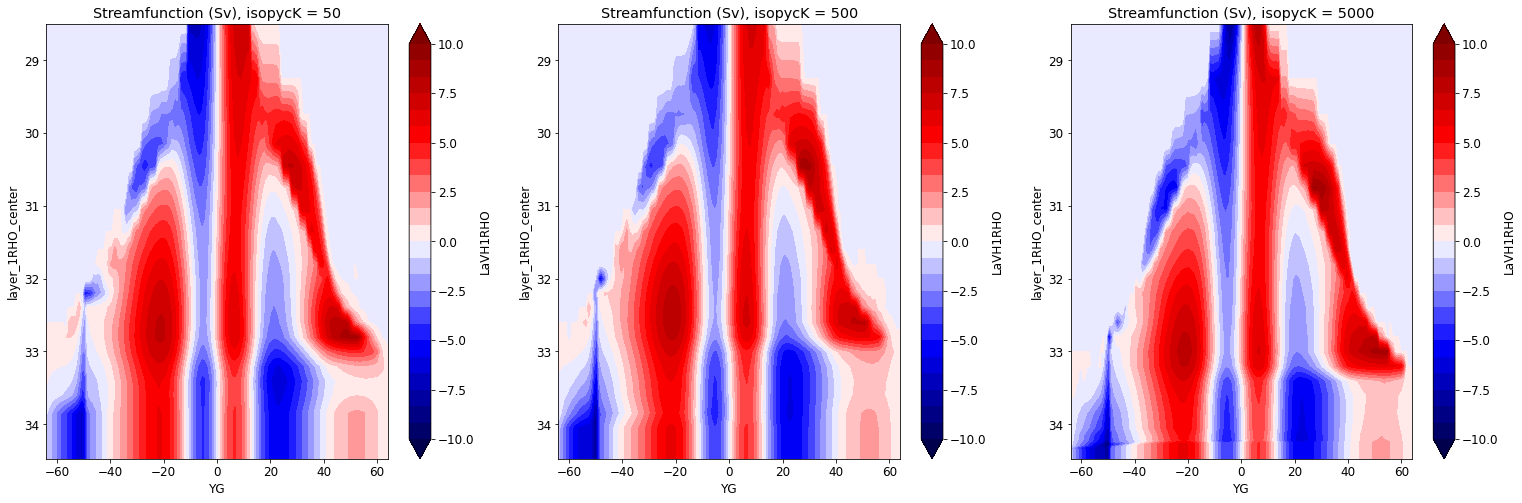

In [61]:
fig, axs = plt.subplots(ncols=3,figsize=(26,8))
#levels = np.arange(-2.5,2.5,.05)
mins=-10
maxs=10
cmap='seismic'
a = (stream50/1e6).plot.contourf(ax = axs[0],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
b = (stream500/1e6).plot.contourf(ax = axs[1],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
C = (stream5000/1e6).plot.contourf(ax = axs[2],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
axs[0].set_title('Streamfunction (Sv), isopycK = 50'),
axs[1].set_title('Streamfunction (Sv), isopycK = 500')
axs[2].set_title('Streamfunction (Sv), isopycK = 5000')
plt.savefig('stream1.png')

In [58]:
# function to calculate streamfunction in Z coordinates
def dynstreamfunction(dyn):
    weights = dyn['dxG'][:-1,:-1]
    temp=(dyn[['VVEL']]).to_array()
    stream=((temp[:,:,:-1,:-1].weighted(weights).sum('XC'))*temp['drF']).cumsum('Z')[0]
    return stream


In [59]:
MOC50 = dynstreamfunction(dyn50)
MOC500 = dynstreamfunction(dyn500)
MOC5000 = dynstreamfunction(dyn5000)

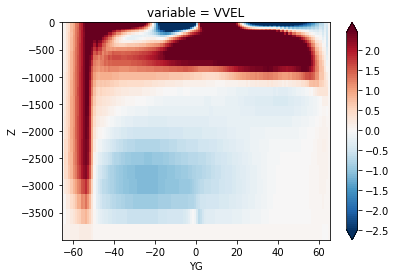

In [128]:
levels = np.arange(-2.5,2.5,.05)
(MOC5000/1e6).plot(levels=levels)
plt.savefig('trough.png')

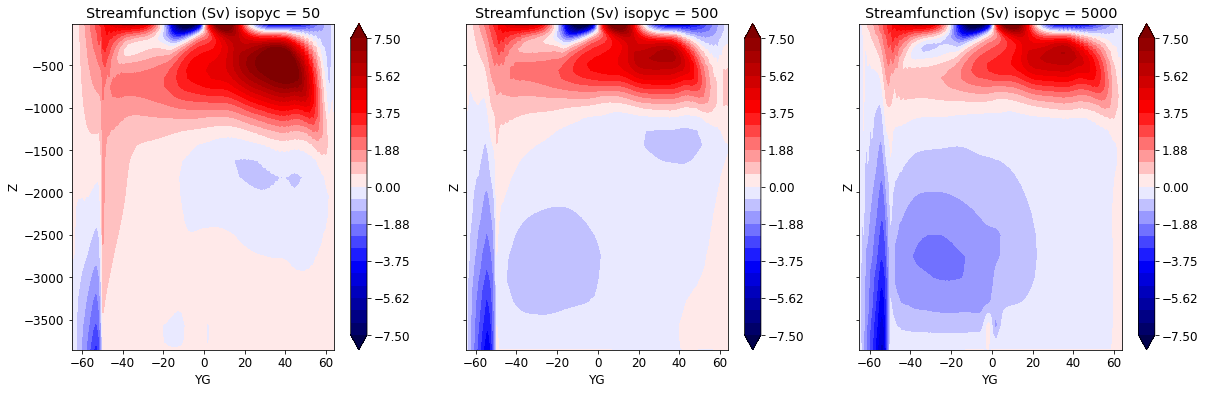

In [60]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(20,6))
mins=-7.5
maxs=7.5
cmap='seismic'
a = (MOC50/1e6).plot.contourf(ax = axs[0],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
b = (MOC500/1e6).plot.contourf(ax = axs[1],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
c = (MOC5000/1e6).plot.contourf(ax = axs[2],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
axs[2].set_title('Streamfunction (Sv) isopyc = 5000')
axs[1].set_title('Streamfunction (Sv) isopyc = 500')
axs[0].set_title('Streamfunction (Sv) isopyc = 50')
plt.savefig('stream.png')

In [42]:
layer=lay5000['LaHs1RHO'].where(lay5000['layer_1RHO_center']<=33.0).sum('layer_1RHO_center')

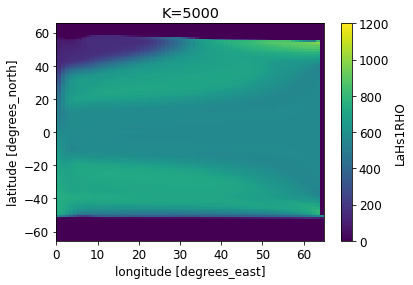

In [43]:
layer.plot(vmin=0,vmax=1200)
plt.title('K=5000')
plt.savefig('layer.png')

In [16]:
\\

TypeError: unhashable type: 'slice'

In [61]:
grid = Grid(dyn50,coords={'Z':{'center':'Z','outer':'Zp1'},'Y':{'center':'YC','left':'YG'}}, periodic=False)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [62]:
layers_bounds =np.array((28.0,29.0,29.5,30.0,30.3,30.6,30.9,31.2,31.5,31.7,31.9,32.1,32.3,32.5,32.7,32.90,33.1,33.3,33.5,33.7,34.0,34.1,34.2,34.21,34.22,34.23,34.24,34.26,34.28,34.3,34.32,34.34,34.36,34.38,34.4,34.45,34.5))

In [63]:
target=dyn5000['rhoRef']*(1-(2e-4*dyn5000['THETA'])+(7.4e-4*(dyn5000['SALT']-35)))-1000
target= grid.interp(target,['Z'],boundary='extend')
target=target[:,:-1,:-1]

In [ ]:
target1=target.isel(XC=50)
target1.plot(vmin=32)

In [69]:
v_transport =  dyn50['VVEL'] * dyn50['drF']
v_transport = v_transport.fillna(0.).rename('v_transport')
v_transport = grid.interp(v_transport,['Y'],boundary='extend')
v_transport=v_transport[:,1:-1,1:-1]

In [66]:
v_transport_theta = grid.transform(v_transport, 'Z', layers_bounds,
                                   target_data=target, method='conservative')
v_transport_theta=(v_transport_theta.where(v_transport_theta['TRANSFORMED_DIMENSION']<=32.8,drop=True)*dyn50['dxF'][:-1,:-1]).sum('TRANSFORMED_DIMENSION').sum('XC')
#v_transport_theta.plot()

/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/grid.py:982: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [43]:
def transformed(dyn,limit):
    grid = Grid(dyn,coords={'Z':{'center':'Z','outer':'Zp1'},'Y':{'center':'YC','left':'YG'}}, periodic=False)
    layers_bounds =np.array((28.0,29.0,29.5,30.0,30.3,30.6,30.9,31.2,31.5,31.7,31.9,32.1,32.3,32.5,32.7,32.90,33.1,33.3,33.5,33.7,34.0,34.1,34.2,34.21,34.22,34.23,34.24,34.26,34.28,34.3,34.32,34.34,34.36,34.38,34.4,34.45,34.5))
    target=dyn['rhoRef']*(1-(2e-4*dyn['THETA'])+(7.4e-4*(dyn['SALT']-35)))-1000
    target= grid.interp(target,['Z'],boundary='extend')
    target=target[:,:-1,:-1]
    v_transport =  dyn['VVEL'] * dyn['drF']
    v_transport = v_transport.fillna(0.).rename('v_transport')
    v_transport = grid.interp(v_transport,['Y'],boundary='extend')
    v_transport=v_transport[:,:-1,:-1]
    v_transport_theta = grid.transform(v_transport, 'Z', layers_bounds, target_data=target, method='conservative')
    v_transport_theta=((((v_transport_theta.where(v_transport_theta['TRANSFORMED_DIMENSION']<=limit,drop=True).sum('TRANSFORMED_DIMENSION'))[:-1,:-1])*dyn50['dxF']).mean('XC'))
    return v_transport_theta

/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/grid.py:982: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/grid.py:1019: UserWarning: Input`target_data` has no name, but we need a name for the transformed dimension. The name `TRANSFORMED_DIMENSION` will be used. To avoid this warning, call `.rename` on `target_data` before calling `transform`.
  warnings.warn(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/sit

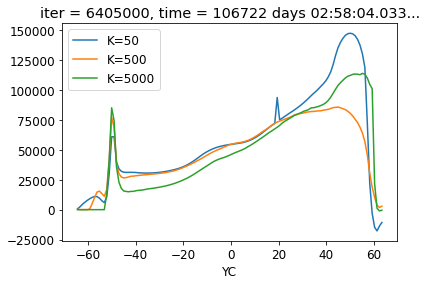

In [44]:
V50 = transformed(dyn50,32.8)
V500 = transformed(dyn500,32.6)
V5000 = transformed(dyn5000,33.0)
V50.plot(label='K=50')
V500.plot(label='K=500')
V5000.plot(label='K=5000')
plt.legend()
plt.savefig('transformed.png')

In [49]:
def transformedones(dyn,limit):
    grid = Grid(dyn,coords={'Z':{'center':'Z','outer':'Zp1'},'Y':{'center':'YC','left':'YG'}}, periodic=False)
    layers_bounds =np.array((28.0,29.0,29.5,30.0,30.3,30.6,30.9,31.2,31.5,31.7,31.9,32.1,32.3,32.5,32.7,32.90,33.1,33.3,33.5,33.7,34.0,34.1,34.2,34.21,34.22,34.23,34.24,34.26,34.28,34.3,34.32,34.34,34.36,34.38,34.4,34.45,34.5))
    target=dyn['rhoRef']*(1-(2e-4*dyn['THETA'])+(7.4e-4*(dyn['SALT']-35)))-1000
    target= grid.interp(target,['Z'],boundary='extend')
    target=target[:,:-1,:-1]
    v_transport =  dyn['VVEL'] * dyn['drF']
    v_transport = v_transport.fillna(0.).rename('v_transport')
    v_transport = grid.interp(v_transport,['Y'],boundary='extend')
    v_transport=v_transport[:,:-1,:-1]
    v_transport_theta = grid.transform(xr.ones_like(v_transport)* dyn['drF'], 'Z', layers_bounds, target_data=target, method='conservative')
    v_transport_theta=((((v_transport_theta.where(v_transport_theta['TRANSFORMED_DIMENSION']<=limit,drop=True).sum('TRANSFORMED_DIMENSION'))[:-1,:-1])))
    return v_transport_theta

In [50]:
def transformedTheta(dyn,limit):
    grid = Grid(dyn,coords={'Z':{'center':'Z','outer':'Zp1'},'Y':{'center':'YC','left':'YG'}}, periodic=False)
    layers_bounds =np.array((28.0,29.0,29.5,30.0,30.3,30.6,30.9,31.2,31.5,31.7,31.9,32.1,32.3,32.5,32.7,32.90,33.1,33.3,33.5,33.7,34.0,34.1,34.2,34.21,34.22,34.23,34.24,34.26,34.28,34.3,34.32,34.34,34.36,34.38,34.4,34.45,34.5))
    target=dyn['rhoRef']*(1-(2e-4*dyn['THETA'])+(7.4e-4*(dyn['SALT']-35)))-1000
    target= grid.interp(target,['Z'],boundary='extend')
    target=target[:,:-1,:-1]
    v_transport =  dyn['THETA'] * dyn['drF']
    v_transport = v_transport.fillna(0.).rename('v_transport')
    #v_transport = grid.interp(v_transport,['Y'],boundary='extend')
    v_transport=v_transport[:,:-1,:-1]
    v_transport_theta = grid.transform(v_transport, 'Z', layers_bounds, target_data=target, method='conservative')
    v_transport_theta=((((v_transport_theta.where(v_transport_theta['TRANSFORMED_DIMENSION']<=limit,drop=True).sum('TRANSFORMED_DIMENSION'))[:-1,:-1])))
    return v_transport_theta

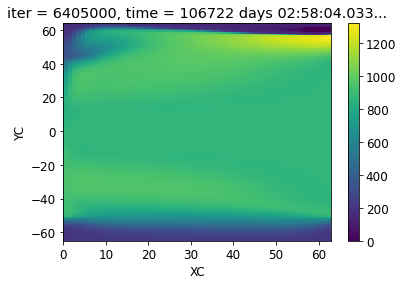

In [53]:
V50.plot()

/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/grid.py:982: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/grid.py:1019: UserWarning: Input`target_data` has no name, but we need a name for the transformed dimension. The name `TRANSFORMED_DIMENSION` will be used. To avoid this warning, call `.rename` on `target_data` before calling `transform`.
  warnings.warn(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/sit

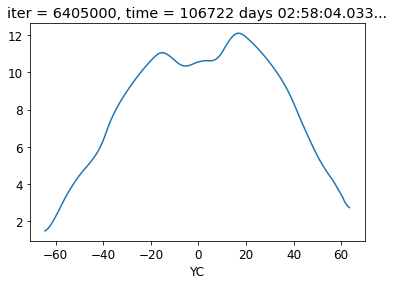

In [52]:
V50 = transformedones(dyn50,32.8)
V50T = transformedTheta(dyn50,32.8)
Theta= V50T/V50
#V50 = transformedones(dyn50,32.8)
(Theta.mean('XC')).plot()